# Learmonth (25-180MHz)

https://www.sws.bom.gov.au/World_Data_Centre/1/9

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator

In [75]:
def read_learmonth_srs(file_path):
    """
    Reads a Learmonth SRS file and returns:
      - times: list of timestamp strings,
      - frequencies: a 2D numpy array (one row per record) of the concatenated frequency axis (MHz),
      - intensities: a 2D numpy array (one row per record) of the amplitude (dBm) data.
      
    Assumptions:
      - Each record is 826 bytes:
            8 bytes header +
            2 × (8 bytes channel header + 401 bytes channel data)
      - Channel 1 header is assumed to be correct and its values (stored multiplied by 256)
        yield a frequency axis of approximately 25–75 MHz.
      - Channel 2 header values are unreliable, so we force its frequency axis to be
        np.linspace(75, 180, 401) (i.e. exactly 75–180 MHz).
    """
    with open(file_path, "rb") as f:
        data = f.read()
    
    record_size = 8 + 2 * (8 + 401)  # 8 + 2*409 = 826 bytes per record
    num_records = len(data) // record_size

    times = []
    frequencies = []
    intensities = []
    index = 0

    for rec in range(num_records):
        # --- Read record header (8 bytes) ---
        header = data[index:index+8]
        year, month, day, hour, minute, second, _, _ = struct.unpack("8B", header)
        index += 8
        # Adjust year: assume < 90 means 2000s, else 1900s
        if year < 90:
            year += 2000
        else:
            year += 1900
        timestamp = f"{year}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}:{second:02d}"
        times.append(timestamp)

        # --- Process Channel 1 ---
        ch1_header = data[index:index+8]
        start1, end1, resbw1, ref_level1, rnge1 = struct.unpack("3H2B", ch1_header)
        index += 8
        # Build channel 1 frequency axis (divide by 256)
        freq_ch1 = np.linspace(start1, end1, 401) / 256.0

        # Read channel 1 data (401 bytes)
        raw_intensity1 = np.frombuffer(data[index:index+401], dtype=np.uint8)
        index += 401
        intensity1 = raw_intensity1.astype(np.int16)
        intensity1[intensity1 >= 128] -= 256

        # --- Process Channel 2 ---
        # Skip channel 2 header (8 bytes)
        index += 8
        # Force channel 2 frequency axis to be exactly 75–180 MHz.
        freq_ch2 = np.linspace(75, 180, 401)
        # Read channel 2 data (401 bytes)
        raw_intensity2 = np.frombuffer(data[index:index+401], dtype=np.uint8)
        index += 401
        intensity2 = raw_intensity2.astype(np.int16)
        intensity2[intensity2 >= 128] -= 256

        # # (Optional debug prints)
        # print(f"Record {rec}, Channel 1: {freq_ch1[0]:.2f} MHz to {freq_ch1[-1]:.2f} MHz")
        # print(f"Record {rec}, Channel 2 (forced): {freq_ch2[0]:.2f} MHz to {freq_ch2[-1]:.2f} MHz")

        # Concatenate the two channels (resulting in 802 points per record)
        full_freq = np.concatenate([freq_ch1, freq_ch2])
        full_intensity = np.concatenate([intensity1, intensity2])
        frequencies.append(full_freq)
        intensities.append(full_intensity)
    
    return times, np.array(frequencies), np.array(intensities)


def plot_learmonth_srs(file_path, start_time, end_time, min_frequency, max_frequency, time_interval, frequency_interval, vmin=False, vmax=False):
    """
    Plots a dynamic spectrum for a Learmonth SRS file over a specified time and frequency range.
    
    Parameters:
      file_path     : Path to the SRS file.
      start_time    : Datetime object for the start time.
      end_time      : Datetime object for the end time.
      min_frequency : Minimum frequency (MHz) to display.
      max_frequency : Maximum frequency (MHz) to display.
      vmin, vmax    : If False, they are computed from the 5th and 95th percentiles of the data.
    
    Additional modifications:
      - The y-axis is plotted on a logarithmic scale.
      - No intensity normalization is performed.
      - The colorbar is not plotted.
    """
    times_str, freqs, intensities = read_learmonth_srs(file_path)
    # Convert timestamp strings to datetime objects.
    times_dt = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in times_str]
    
    # Select records within the specified time range.
    indices = [i for i, t in enumerate(times_dt) if start_time <= t <= end_time]
    if not indices:
        print("No data found in the specified time range.")
        return
    selected_times = np.array(times_dt)[indices]
    time_nums = mdates.date2num(selected_times)
    # Compute time cell edges (assuming uniform spacing)
    if len(time_nums) > 1:
        dt_num = time_nums[1] - time_nums[0]
    else:
        dt_num = 1/86400.0  # one second in days
    time_edges = np.concatenate(([time_nums[0] - dt_num/2],
                                 (time_nums[:-1] + time_nums[1:]) / 2,
                                 [time_nums[-1] + dt_num/2]))
    
    # Use the frequency axis from the first record.
    full_freq_axis = freqs[0]  # Should be 802 points spanning 25–180 MHz.
    # Create a mask for the desired frequency range.
    freq_mask = (full_freq_axis >= min_frequency) & (full_freq_axis <= max_frequency)
    if not np.any(freq_mask):
        print("No data found in the specified frequency range.")
        return
    freq_axis_trimmed = full_freq_axis[freq_mask]
    
    # Extract the corresponding intensity data (without normalization).
    intensities_selected = intensities[indices, :][:, freq_mask]
    
    # Determine vmin and vmax automatically if not provided.
    if vmin is False:
        vmin = np.percentile(intensities_selected, 5)
    if vmax is False:
        vmax = np.percentile(intensities_selected, 95)
    
    # Compute frequency cell edges from midpoints.
    df = np.diff(freq_axis_trimmed)
    df_first = df[0] if len(df) > 0 else 0.1
    freq_edges = np.concatenate(([freq_axis_trimmed[0] - df_first/2],
                                  (freq_axis_trimmed[:-1] + freq_axis_trimmed[1:]) / 2,
                                  [freq_axis_trimmed[-1] + df[-1]/2]))
    
    
    #######################################################
    # Plot the dynamic spectrum
    fig, ax = plt.subplots(figsize=(12, 6))
    mesh = ax.pcolormesh(time_edges, freq_edges, intensities_selected.T, shading='auto',
                        cmap='jet', vmin=vmin, vmax=vmax)
    # カラーバーは表示しない
    
    
    # 軸設定
    ax.set_xlim(mdates.date2num(start_time), mdates.date2num(end_time))
    ax.set_ylim(min_frequency, max_frequency)
    ax.set_xlabel("Time [UT]", fontsize=18)
    ax.set_ylabel("Frequency (MHz)", fontsize=18)
    ax.set_title("Learmonth Solar Radio Spectrogram (25-180 MHz)", fontsize=20)
    
    # X軸の目盛りの間隔を time_interval (秒) に設定（SecondLocatorを使用）
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=time_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # fig.autofmt_xdate()
    
    # Y軸は対数スケールに設定し、1MHz間隔の目盛りを固定位置として設定
    ax.set_yscale("log")
    # 対数スケールで1MHz刻みの目盛りを表示するため、固定の目盛り位置を指定
    y_ticks = np.arange(min_frequency, max_frequency + frequency_interval, frequency_interval)
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    
    # 軸目盛のフォントサイズを設定
    ax.tick_params(axis='both', labelsize=16)
    
    plt.show()



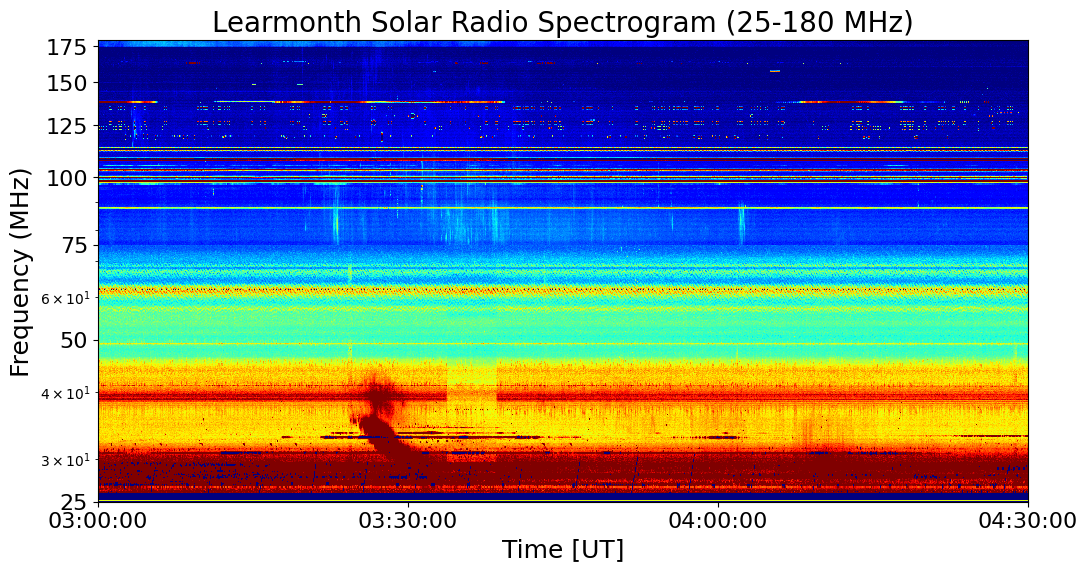

In [76]:
file_path = "/home/kinno-7010/Research/Radio data/Learmonth/Rawdata/LM220613.srs"
# Define the time range (as datetime objects)
start_time = datetime(2022, 6, 13, 3, 0, 0)
end_time   = datetime(2022, 6, 13, 4, 30, 0)

# Set the frequency display range (MHz)
min_frequency = 25
max_frequency = 180

time_interval = 30*60
frequency_interval = 25

# vmin and vmax are False to auto-scale using percentiles.
plot_learmonth_srs(file_path, start_time, end_time, min_frequency, max_frequency, time_interval, frequency_interval, vmin=False, vmax=False)

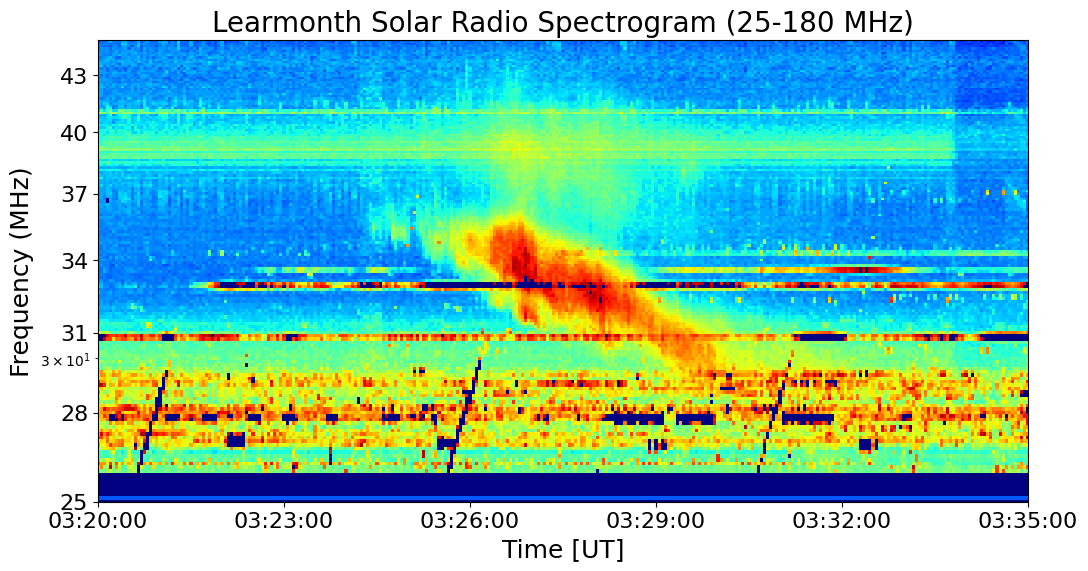

In [77]:
file_path = "/home/kinno-7010/Research/Radio data/Learmonth/Rawdata/LM220613.srs"
# Define the time range (as datetime objects)
start_time = datetime(2022, 6, 13, 3, 20, 0)
end_time   = datetime(2022, 6, 13, 3, 35, 0)

# Set the frequency display range (MHz)
min_frequency = 25
max_frequency = 45

time_interval = 3*60
frequency_interval = 3

# vmin and vmax are False to auto-scale using percentiles.
plot_learmonth_srs(file_path, start_time, end_time, min_frequency, max_frequency, time_interval, frequency_interval,
                        vmin=60, vmax=130)